### Problem Statement
It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:
<br>Do any of your classifiers seem to overfit?
<br>Which seem to perform the best? Why?
<br>Which features seemed to be most impactful to performance?
### Outline
Version 1: Original
<br>Version 2: Positive word value count
<br>Version 3: Negative word value count
<br>Version 4: Combine correlated features: negative sentiment
<br>Version 5: Combine correlated features: positive sentiment
<br>Write Up

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import random
from collections import Counter
import operator
import seaborn as sns
import re
data_path = "data/imdb_labelled.txt"
reviews_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
reviews_raw.columns = ['review', 'positive']
# clean up the review strings
reviews_raw['review'] = reviews_raw['review']\
    .str.lower()\
    .str.replace('.','')\
    .str.replace(',','')\
    .str.replace('!','')\
    .str.replace('?','')\
    .str.replace("'",'')\
    .str.replace('\t','')\
    .str.replace('\n','')\
    .str.replace('\d','')

In [2]:
def keyword_features(df, keywords):
    df_keywords = df.copy()
    for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
        df_keywords[str(key)] = df_keywords.review.str.contains(
            ' ' + str(key) + ' ',
            case=False
        )
    return df_keywords

def evaluate_version(df, keywords, target):
    random.seed(120)
    bnb = BernoulliNB()
    data = df[keywords]
    total_points = data.shape[0]
    # baseline
    baseline = (target == True).sum()
    train_test_score = bnb.fit(data, target).score(data, target)
    print ("Baseline positive: {}".format(round(1 - baseline / total_points, 3) ))
    print ("Train = Test Score: {}".format(round(train_test_score, 3)))
    # folds
    random_array = list(range(total_points))
    random.shuffle(random_array)
    random_series = pd.Series(random_array)
    folds = 10
    fold_scores = np.zeros(folds)
    fold_sens = np.zeros(folds)
    fold_spec = np.zeros(folds)
    fold_size = int(total_points / folds)
    
    # cross validation
    for fold in range(folds):
        test_vals = list(random_series[fold * fold_size:(fold + 1) * fold_size])
        train_vals = list(random_series)
        train_vals = list(set(train_vals) - set(test_vals))
        fold_X_train = data.iloc[train_vals]
        fold_X_test = data.iloc[test_vals]
        fold_Y_train = target.iloc[train_vals]
        fold_Y_test = target.iloc[test_vals]
        fold_fit = bnb.fit(fold_X_train, fold_Y_train)
        fold_pred = bnb.predict(fold_X_test)
        fold_scores[fold] = fold_fit.score(fold_X_test, fold_Y_test)
        # confusion matrix
        spam_confusion_matrix = confusion_matrix(fold_Y_test, fold_pred)
        # sensitivity / specificity
        fold_sens[fold] = round(spam_confusion_matrix[0][0] / (spam_confusion_matrix[0][0] + spam_confusion_matrix[0][1]), 3)
        fold_spec[fold] = round(spam_confusion_matrix[1][0] / (spam_confusion_matrix[1][0] + spam_confusion_matrix[1][1]), 3)
    fold_df = pd.DataFrame(data = np.transpose([fold_scores, fold_sens, fold_spec]), columns = ['Score', 'Sensitivity', 'Specificity'])
    print (fold_df)
    print ("Means\n{}".format(fold_df.mean()))
    print ("Standard Deviations\n{}".format(fold_df.std()))

### Version 1: Original

In [3]:
keywords_v1 = ['superb', 'amazing', 'interesting', 'good', 'great', 'best', 'love', 'perfect', 'masterpiece', 'beautiful', 'excellent', 'wonderful', 'art', 'like', 'liked', 'enjoy', 'enjoyed']
target_v1 = reviews_raw['positive']

reviews_v1 = keyword_features(reviews_raw, keywords_v1)

evaluate_version(reviews_v1, keywords_v1, target_v1)

Baseline positive: 0.484
Train = Test Score: 0.632
      Score  Sensitivity  Specificity
0  0.608108        0.933        0.614
1  0.621622        0.941        0.650
2  0.540541        1.000        0.791
3  0.689189        0.884        0.581
4  0.662162        0.919        0.595
5  0.689189        1.000        0.590
6  0.608108        0.897        0.714
7  0.702703        1.000        0.564
8  0.621622        0.838        0.595
9  0.554054        0.917        0.789
Means
Score          0.62973
Sensitivity    0.93290
Specificity    0.64830
dtype: float64
Standard Deviations
Score          0.055972
Sensitivity    0.054472
Specificity    0.085876
dtype: float64


### Only-positive and only-negative words

In [4]:
# value counts of negative sentiment reviews
pos_reviews = reviews_raw[reviews_raw['positive'] == 1]
pos_string = ' '.join(pos_reviews['review'])
pos_words_count = dict(Counter(pos_string.split(" ")))
pos_words = list(pos_words_count.keys())

neg_reviews = reviews_raw[reviews_raw['positive'] == 0]
neg_string = ' '.join(neg_reviews['review'])
neg_words_count = dict(Counter(neg_string.split(" ")))
neg_words = list(neg_words_count.keys())

# only positive words
only_pos_words = [x for x in pos_words if x not in neg_words]
only_pos_words_dict = { key: pos_words_count[key] for key in only_pos_words }
top_pos_words = [x for x in only_pos_words_dict if only_pos_words_dict[x] > 3]
print (top_pos_words)
# only negative words
only_neg_words = [x for x in neg_words if x not in pos_words]
only_neg_words_dict = { key: neg_words_count[key] for key in only_neg_words }
top_neg_words = [x for x in only_neg_words_dict if only_neg_words_dict[x] > 3]
print (top_neg_words)

['song', 'hilarious', 'tale', 'true', 'interesting', 'terrific', 'occasionally', 'joy', 'brilliant', 'silent', 'entertaining', 'become', 'roles', 'parts', 'role', 'superb', 'fine', 'fans', 'beginning', 'appreciate', 'sucks']
['poor', 'wasted', 'hours', 'low', 'money', 'idea', 'mediocre', 'away', 'worst', 'whatever', 'glad', 'hard', 'annoying', 'theyre', 'wouldnt', 'pretentious', 'extremely', 'couldnt', 'awful', 'unfortunately', 'depth', 'imagination', 'sucked', 'storyline', 'mean', 'torture', 'else', 'pathetic', 'cheap', 'trash', 'three', 'intelligence', 'involved', 'place', 'unbelievable']


### Version 2: Positive word value count

In [5]:
keywords_v2 = top_pos_words

target_v2 = reviews_raw['positive'].astype(bool) # evaluate positive keywords on positive sentiments

reviews_v2 = keyword_features(reviews_raw, keywords_v2)

evaluate_version(reviews_v2, keywords_v2, target_v2)

Baseline positive: 0.484
Train = Test Score: 0.591
      Score  Sensitivity  Specificity
0  0.486486          1.0        0.864
1  0.594595          1.0        0.750
2  0.527027          1.0        0.814
3  0.702703          1.0        0.710
4  0.581081          1.0        0.838
5  0.554054          1.0        0.846
6  0.662162          1.0        0.714
7  0.608108          1.0        0.744
8  0.594595          1.0        0.811
9  0.594595          1.0        0.789
Means
Score          0.590541
Sensitivity    1.000000
Specificity    0.788000
dtype: float64
Standard Deviations
Score          0.061779
Sensitivity    0.000000
Specificity    0.055564
dtype: float64


### Version 3: Negative word value count 

In [6]:
keywords_v3 = top_neg_words

target_v3 = ~(reviews_raw['positive'].astype(bool)) # negate positive scores to evaluate negative keywords on negative sentiments

reviews_v3 = keyword_features(reviews_raw, keywords_v3)

evaluate_version(reviews_v3, keywords_v3, target_v3)

Baseline positive: 0.516
Train = Test Score: 0.643
      Score  Sensitivity  Specificity
0  0.675676          1.0        0.800
1  0.675676          1.0        0.706
2  0.743243          1.0        0.613
3  0.621622          1.0        0.651
4  0.621622          1.0        0.757
5  0.608108          1.0        0.829
6  0.621622          1.0        0.718
7  0.621622          1.0        0.800
8  0.675676          1.0        0.649
9  0.581081          1.0        0.861
Means
Score          0.644595
Sensitivity    1.000000
Specificity    0.738400
dtype: float64
Standard Deviations
Score          0.047265
Sensitivity    0.000000
Specificity    0.084325
dtype: float64


### Version 4: Combine correlated features: positive sentiment

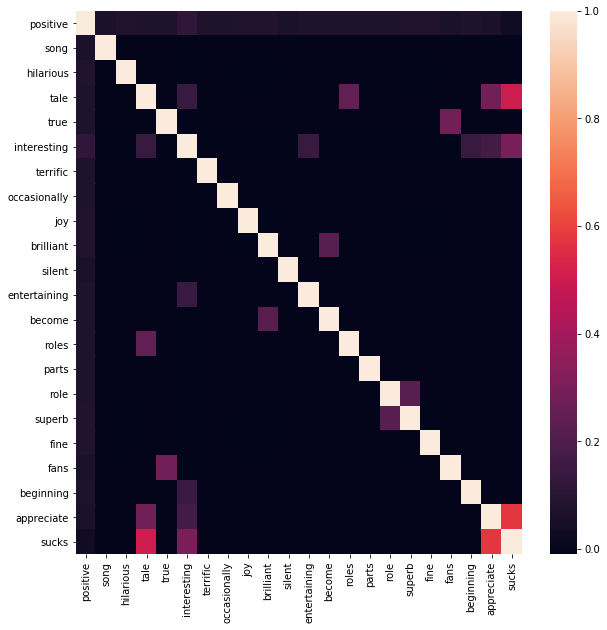

In [7]:
# get autocorrelation of positive sentiment words from v3
v2_corr = reviews_v2.corr()
plt.figure(figsize = (10,10))
sns.heatmap(v2_corr)
plt.show()

In [8]:
def combine_correlated_keywords(df, v_corr, correlation_cutoff = 0.5):
    df_temp = df.copy()
    combined_keywords = set()
    combined_columns = set()
    for column in v_corr.columns:
        rows = v_corr[column][v_corr[column] > correlation_cutoff].index.values # select indices with correlations above correlation_cutoff
        rows = rows[rows != column] # get rid of autocorrelation
        combined_words = [tuple(sorted([row, column])) for row in rows] # get list of correlated keywords for this column
        combined_keywords.update(combined_words) # add to list of correlated keywords for dataframe
        if rows.size:
            combined_columns.update([column]) # add columns which had any correlation above correlation_cutoff
    for combined_keyword in combined_keywords:
        df_temp[combined_keyword[0] + "/" + combined_keyword[1]] = df_temp[combined_keyword[0]] | df_temp[combined_keyword[1]]

    df_temp.drop(labels = list(combined_columns), axis = 1, inplace = True)

    keywords = df_temp.drop(labels = ['review', 'positive'], axis = 1).columns
    return df_temp, keywords

In [9]:
reviews_v4, keywords_v4 = combine_correlated_keywords(reviews_v2, reviews_v2.corr(), correlation_cutoff = 0.3)

target_v4 = target_v2.copy() # positive sentiments

evaluate_version(reviews_v4, keywords_v4, target_v4)

Baseline positive: 0.484
Train = Test Score: 0.591
      Score  Sensitivity  Specificity
0  0.486486          1.0        0.864
1  0.594595          1.0        0.750
2  0.527027          1.0        0.814
3  0.702703          1.0        0.710
4  0.581081          1.0        0.838
5  0.554054          1.0        0.846
6  0.662162          1.0        0.714
7  0.608108          1.0        0.744
8  0.594595          1.0        0.811
9  0.594595          1.0        0.789
Means
Score          0.590541
Sensitivity    1.000000
Specificity    0.788000
dtype: float64
Standard Deviations
Score          0.061779
Sensitivity    0.000000
Specificity    0.055564
dtype: float64


### Version 5: Combine correlated features: negative sentiment

In [12]:
reviews_v5, keywords_v5 = combine_correlated_keywords(reviews_v3, reviews_v3.corr())

target_v5 = target_v3.copy() # negative sentiments

evaluate_version(reviews_v5, keywords_v5, target_v5)

Baseline positive: 0.516
Train = Test Score: 0.643
      Score  Sensitivity  Specificity
0  0.675676          1.0        0.800
1  0.675676          1.0        0.706
2  0.743243          1.0        0.613
3  0.621622          1.0        0.651
4  0.621622          1.0        0.757
5  0.608108          1.0        0.829
6  0.621622          1.0        0.718
7  0.621622          1.0        0.800
8  0.689189          1.0        0.622
9  0.581081          1.0        0.861
Means
Score          0.645946
Sensitivity    1.000000
Specificity    0.735700
dtype: float64
Standard Deviations
Score          0.048431
Sensitivity    0.000000
Specificity    0.087864
dtype: float64


### Write-up
Version 1 represent a biased sampling of words from positive sentiment indices. I chose words that I thought sounded positive in the review. The average score from cross-validation was 62.9%. This method performed much better than the baseline positive score, however, would not work for other production level models. 
<br>The first attempt to improve the features (in version 2) was to find the most popular words in  the positive sentiment reviews (all similar words in negative sentiment reviews were omitted). Feeding those keywords into the Naive Bayes model provided a score of 59.1%.
<br>For version 3, a similar method was used, but with negative sentiment keywords. This model scored 64.5% accuracy. 
<br>The last two models use a correlation matrix to determine which features to combine. Both positive and negative sentiment keywords were used for versions 4 and 5 respectively. These models performed slightly better than their single-word feature counterparts. Version 4 scored the exact same as the single-word feature version. However, version 5 scored 64.6%, a 0.1% increase over its counterpart. 